In [1]:
import numpy as np
import json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from datetime import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
%load_ext tensorboard

In [2]:
# Here to pre-process the data input
places = []
labels = []
training_places = []
training_labels = []
testing_places = []
testing_labels = []

with open("/tmp/TourismSitesIndonesia.json", 'r') as f:
    datastore = json.load(f)

# to access: print(datastore['results'][2]['name'])
for item in datastore['results']:
  if (item['types'] != [""]): 
    places.append(item['name'])
    labels.append(item['types'])

In [3]:
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels)
class_types = one_hot.classes_

In [ ]:
def extractPlaces(lst):
  return list(map(lambda x:[x], lst))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((extractPlaces(places),
                                              labels))

In [4]:
# shuffle data
places_shuffled, labels_shuffled = shuffle(places, labels)

num_split = int(0.7*len(places)) # change from 0.8 to 0.7

# split data testing and training
training_places = places_shuffled[:num_split]
training_labels = labels_shuffled[:num_split]
testing_places = places_shuffled[num_split:]
testing_labels = labels_shuffled[num_split:]

In [5]:
f = pd.DataFrame(data=labels_shuffled,
                 index=places_shuffled,
                 columns=class_types)
# f # uncomment to show data frame (all data)

g = pd.DataFrame(data=training_labels,
                 index=training_places,
                 columns=class_types)
# g # uncomment to show data frame (training data)

h = pd.DataFrame(data=testing_labels,
                 index=testing_places,
                 columns=class_types)
# h # uncomment to show data frame (testing data)

In [6]:
vocab_size = 12000
embedding_dim = 64
max_length = 10
trunc_type = 'post'
oov_tok = "<OOV>"

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_places)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_places)
training_padded = pad_sequences(sequences,
                                maxlen=max_length,
                                truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_places)
testing_padded = pad_sequences(testing_sequences)

In [29]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, ## formerly: vocab_size
                            embedding_dim,
                            input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(5, activation='softmax') 
])

# kategori: **Budaya, Sejarah, Cagar Alam, Maritim, Religi**

model.compile(loss="categorical_crossentropy",
              metrics=["accuracy"],
              optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 64)            768000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 859,141
Trainable params: 859,141
Non-trainable params: 0
_________________________________________________________________


In [30]:
DESIRED_ACCURACY = 0.99

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>DESIRED_ACCURACY):
            print("\nReached threshold accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [31]:
num_epochs = 100

history = model.fit(training_padded, training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded,testing_labels),
                    verbose = 1,
                    batch_size = 16, # change from 64 -> 8
                    callbacks = [callbacks])

Epoch 1/100
18/18 [==============================] - 4s 68ms/step - loss: 2.1466 - accuracy: 0.1910 - val_loss: 1.9714 - val_accuracy: 0.3710
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 2.1470 - accuracy: 0.3299 - val_loss: 2.0526 - val_accuracy: 0.3710
Epoch 3/100
18/18 [==============================] - 0s 22ms/step - loss: 2.1021 - accuracy: 0.3854 - val_loss: 1.9580 - val_accuracy: 0.3710
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 2.0152 - accuracy: 0.3854 - val_loss: 1.9468 - val_accuracy: 0.3710
Epoch 5/100
18/18 [==============================] - 0s 21ms/step - loss: 1.9993 - accuracy: 0.3854 - val_loss: 1.9429 - val_accuracy: 0.3710
Epoch 6/100
18/18 [==============================] - 0s 20ms/step - loss: 2.0030 - accuracy: 0.3854 - val_loss: 1.9402 - val_accuracy: 0.3710
Epoch 7/100
18/18 [==============================] - 0s 20ms/step - loss: 1.9966 - accuracy: 0.3854 - val_loss: 1.9389 - val_accuracy: 0.3710
Epoch 

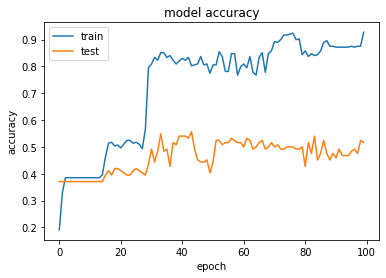

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

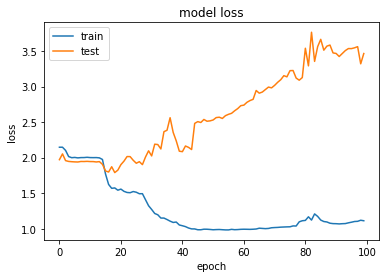

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# to be done after training is finished

import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [38]:
!pwd

/content


In [ ]:
!sudo pip install tensorflowjs
!tensorflowjs_converter --input_format=keras {saved_model_path} ./